# Chp 12: Part 2

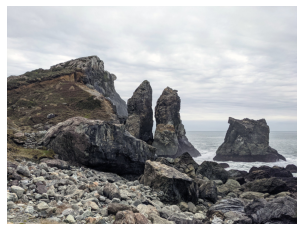

In [24]:
# 12.2.1 Implementing DeepDream in Keras
def listing12_2_1():
    import tensorflow as tf
    from tensorflow import keras

    import matplotlib.pyplot as plt

    base_image_path = keras.utils.get_file(
        "coast.jpg", 
        origin="https://img-datasets.s3.amazonaws.com/coast.jpg"
    )

    plt.axis("off")

    plt.imshow(tf.keras.preprocessing.image.load_img(base_image_path))
    return base_image_path

base_image_path = listing12_2_1()

In [25]:
step = 20.
num_octave = 3
octave_scale = 1.4
iterations = 30
max_loss = 15.

In [39]:
def listing12_2_2():
    from tensorflow import keras
    from tensorflow.keras.applications import inception_v3

    model = inception_v3.InceptionV3(
        weights="imagenet", 
        include_top=False
    )

    layer_settings = {
        "mixed4": 1.0,
        "mixed5": 1.5,
        "mixed6": 2.0,
        "mixed7": 2.5,
    }
    outputs_dict = dict(
        [
            (layer.name, layer.output)
            for layer in [model.get_layer(name) for name in layer_settings.keys()]
        ]
    )
    feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)

    return model, feature_extractor, layer_settings

model, feature_extractor, layer_settings = listing12_2_2()

In [40]:
def compute_loss(input_image):
    features = feature_extractor(input_image)
    loss = tf.zeros(shape=())
    for name in features.keys():
        coeff = layer_settings[name]
        activation = features[name]
        loss += coeff * tf.reduce_mean(tf.square(activation[:, 2:-2, 2:-2, :]))
    return loss

In [41]:
@tf.function
def gradient_ascent_step(image, learning_rate):
    with tf.GradientTape() as tape:
        tape.watch(image)
        loss = compute_loss(image)
    grads = tape.gradient(loss, image)
    grads = tf.math.l2_normalize(grads)
    image += learning_rate * grads
    return loss, image

def gradient_ascent_loop(image, iterations, learning_rate, max_loss=None):
    for i in range(iterations):
        loss, image = gradient_ascent_step(image, learning_rate)
        if max_loss is not None and loss > max_loss:
            break
        print(f"... Loss value at step {i}: {loss:.2f}")
    return image

In [42]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

def preprocess_image(image_path):
    img = tf.keras.preprocessing.image.load_img(image_path)
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = keras.applications.inception_v3.preprocess_input(img)
    return img

def deprocess_image(img):
    img = img.reshape((img.shape[1], img.shape[2], 3))
    img /= 2.0
    img += 0.5
    img *= 255.
    img = np.clip(img, 0, 255).astype("uint8")
    return img

In [43]:
def listing12_2_4():
    import tensorflow as tf
    
    original_img = preprocess_image(base_image_path)
    original_shape = original_img.shape[1:3]

    successive_shapes = [original_shape]
    for i in range(1, num_octave):
        shape = tuple([int(dim / (octave_scale ** i)) for dim in original_shape])
        successive_shapes.append(shape)
    successive_shapes = successive_shapes[::-1]

    shrunk_original_img = tf.image.resize(original_img, successive_shapes[0])

    img = tf.identity(original_img)
    for i, shape in enumerate(successive_shapes):
        print(f"Processing octave {i} with shape {shape}")
        img = tf.image.resize(img, shape)
        img = gradient_ascent_loop(
            img, iterations=iterations, learning_rate=step, max_loss=max_loss
        )
        upscaled_shrunk_original_img = tf.image.resize(shrunk_original_img, shape)
        same_size_original = tf.image.resize(original_img, shape)
        lost_detail = same_size_original - upscaled_shrunk_original_img
        img += lost_detail
        shrunk_original_img = tf.image.resize(original_img, shape)

    tf.keras.preprocessing.image.save_img("dream.png", deprocess_image(img.numpy()))

    print("\nDone..")

listing12_2_4()

Processing octave 0 with shape (459, 612)
... Loss value at step 0: 0.80
... Loss value at step 1: 1.07
... Loss value at step 2: 1.44
... Loss value at step 3: 1.82
... Loss value at step 4: 2.15
... Loss value at step 5: 2.50
... Loss value at step 6: 2.84
... Loss value at step 7: 3.18
... Loss value at step 8: 3.50
... Loss value at step 9: 3.83
... Loss value at step 10: 4.22
... Loss value at step 11: 4.55
... Loss value at step 12: 4.94
... Loss value at step 13: 5.28
... Loss value at step 14: 5.66
... Loss value at step 15: 6.00
... Loss value at step 16: 6.32
... Loss value at step 17: 6.69
... Loss value at step 18: 7.01
... Loss value at step 19: 7.37
... Loss value at step 20: 7.68
... Loss value at step 21: 8.02
... Loss value at step 22: 8.32
... Loss value at step 23: 8.54
... Loss value at step 24: 8.91
... Loss value at step 25: 9.14
... Loss value at step 26: 9.48
... Loss value at step 27: 9.69
... Loss value at step 28: 9.99
... Loss value at step 29: 10.27
Process

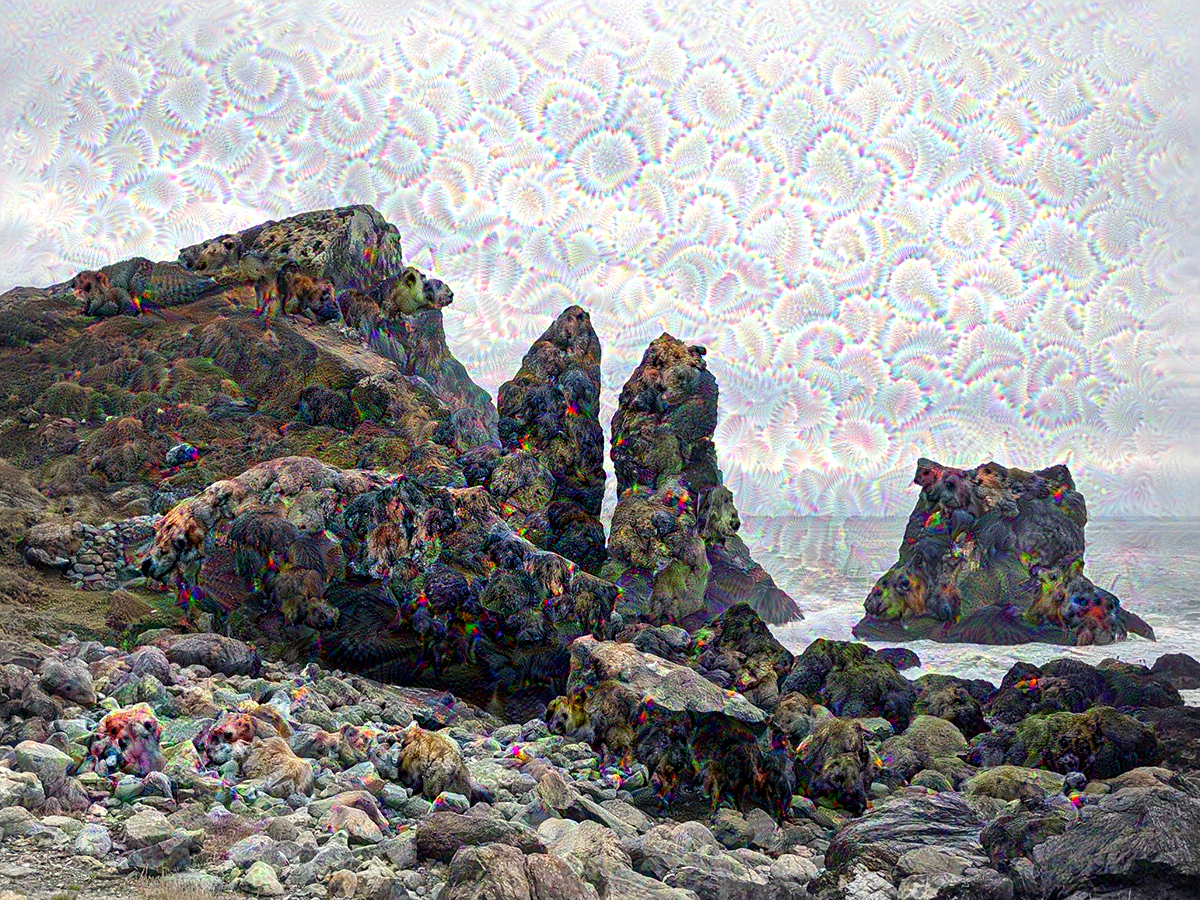

In [44]:
from IPython.display import Image
Image("dream.png")